
![ENEM2017](img/enem-2017.png)

# DataSprints POC


This notebook is a sample analysis for DataSprints Data Analyst position. All data are public and the information here is not confidential.

This notebook is structured as follow:

    1. Loading data;
    2. Data cleaning and selection;
    3. DataFrames of interest will be saved for BI presentation.
    
    
### Analysis goal

In order to achieve the proposed milestones, some features will not be used or even analysed. This work consists on an analysis fo two main aspects of ENEM 2017:

    * Student score on all subjects per region and city
    * Social aspects and how it is realated to the performance.
    
With these two aspects, I intend to give an understanding of the following questions:

1. - What is the average of scores by city and state?
2. - Is there and bias related to the state? Can we realate to some other feature?
3. - What cities present the best and the worst results?
4. - What about the population size? Does it impact on the results?
5. - Looking at some social aspects, did self declared black people perform as well as self declared white people?
6. - Is gender also an important feature when looking to the scores?
7. - People from public schools perform at the same level as private schools?

At the end of this work, it will be presented some insights about the topic and the questions. Then, this work will try to answer all of them with some charts presentations to exemplify the results and support the arguments.

**Note:** Do not expect the results on this notebook, only the data preparation. For results please refer to Power BI dashboard or README.md in the given repository.

In [1]:
# Analysis Tools
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Spark Session
spark = SparkSession \
    .builder \
    .appName("DataSprintsPOC - ENEM 2017") \
    .getOrCreate()

In [3]:
# Loading data frame
df = spark.read.load("data/microdados_enem2017/Microdados Enem 2017/DADOS/MICRODADOS_ENEM_2017.csv",
                    format="csv", sep=";", inferSchema="true", header="true", mode="DROPMALFORMED",
                    encoding= "UTF-8")
df.printSchema()

root
 |-- NU_INSCRICAO: long (nullable = true)
 |-- NU_ANO: integer (nullable = true)
 |-- CO_MUNICIPIO_RESIDENCIA: integer (nullable = true)
 |-- NO_MUNICIPIO_RESIDENCIA: string (nullable = true)
 |-- CO_UF_RESIDENCIA: integer (nullable = true)
 |-- SG_UF_RESIDENCIA: string (nullable = true)
 |-- NU_IDADE: integer (nullable = true)
 |-- TP_SEXO: string (nullable = true)
 |-- TP_ESTADO_CIVIL: integer (nullable = true)
 |-- TP_COR_RACA: integer (nullable = true)
 |-- TP_NACIONALIDADE: integer (nullable = true)
 |-- CO_MUNICIPIO_NASCIMENTO: integer (nullable = true)
 |-- NO_MUNICIPIO_NASCIMENTO: string (nullable = true)
 |-- CO_UF_NASCIMENTO: integer (nullable = true)
 |-- SG_UF_NASCIMENTO: string (nullable = true)
 |-- TP_ST_CONCLUSAO: integer (nullable = true)
 |-- TP_ANO_CONCLUIU: integer (nullable = true)
 |-- TP_ESCOLA: integer (nullable = true)
 |-- TP_ENSINO: integer (nullable = true)
 |-- IN_TREINEIRO: integer (nullable = true)
 |-- CO_ESCOLA: integer (nullable = true)
 |-- CO_MU

In [4]:
# At a glance, this analysis is going to focus on approved essays
df = df.where("TP_STATUS_REDACAO = 1")

In [6]:
# Using spark to evaluate
from pyspark.sql import functions as F
scores = df.groupBy(["SG_UF_RESIDENCIA", "CO_MUNICIPIO_RESIDENCIA"]).agg({'NU_NOTA_CN':'avg', 
                                                                          'NU_NOTA_CH':'avg',
                                                                          'NU_NOTA_LC':'avg', 
                                                                          'NU_NOTA_MT':'avg',
                                                                          'NU_NOTA_COMP1': 'avg',
                                                                          'NU_NOTA_COMP2': 'avg',
                                                                          'NU_NOTA_COMP3': 'avg',
                                                                          'NU_NOTA_COMP4': 'avg',
                                                                          'NU_NOTA_COMP5': 'avg',
                                                                          'NU_NOTA_REDACAO':'avg',
                                                                          'NU_INSCRICAO': 'count'})

In [73]:
social = df.groupBy(["SG_UF_RESIDENCIA", "CO_MUNICIPIO_RESIDENCIA"]).agg({'NU_NOTA_CN':'avg', 
                                                                          'NU_NOTA_CH':'avg',
                                                                          'NU_NOTA_LC':'avg', 
                                                                          'NU_NOTA_MT':'avg',
                                                                          'NU_NOTA_REDACAO':'avg',
                                                                          'NU_INSCRICAO': 'count'})

In [74]:
# Geospatial dataset source: http://www.consultaesic.cgu.gov.br/busca/dados/Lists/Pedido/Item/displayifs.aspx?List=0c839f31-47d7-4485-ab65-ab0cee9cf8fe&ID=425580&Web=88cc5f44-8cfe-4964-8ff4-376b5ebb3bef
# IDH data source: http://www.atlasbrasil.org.br/2013/pt/consulta/
# Brazil population source: https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?edicao=16985&t=resultados

In [75]:
cities = pd.read_csv('data/cities/cidades.csv', names=['nameMun', 'codMun', 'bornMun', 'mainMun', 'area2018',
                                                      'PopMun2019', 'denMun2010', 'Esc6_to_14_2010', 'idhMun2010',
                                                      'ChildrenDeath_per1000born_2010', 'Incomex1000_2017',
                                                      'Costx1000_2017', 'PIB_percapita_2017'], skiprows=1, decimal=',')


cities = cities.drop(['bornMun', 'mainMun', 'denMun2010', 'Esc6_to_14_2010', 'ChildrenDeath_per1000born_2010'], axis=1)

In [76]:
# Cleaning some important features
cities = cities.replace('-', '0')

cities['idhMun2010'] = cities.idhMun2010.str.replace(',','.')
cities['Incomex1000_2017'] = cities.Incomex1000_2017.str.replace(',','.')
cities['Incomex1000_2017'] = cities.Incomex1000_2017.str.replace('Não informado','0')
cities['Costx1000_2017'] = cities.Costx1000_2017.str.replace(',','.')
cities['Costx1000_2017'] = cities.Costx1000_2017.str.replace('Não informado','0')

cities.idhMun2010 = cities.idhMun2010.astype(float)
cities.Incomex1000_2017 = cities.Incomex1000_2017.astype(float)
cities.Costx1000_2017 = cities.Costx1000_2017.astype(float)

In [77]:
cities.head()

,nameMun,codMun,area2018,PopMun2019,idhMun2010,Incomex1000_2017,Costx1000_2017,PIB_percapita_2017
0,Adamantina,3500105,411.987,35068,0.790,160718.67930,137083.66990,30010.56
1,Adolfo,3500204,211.055,3562,0.730,27333.74731,20103.87713,27634.98
2,Aguaí,3500303,474.554,36305,0.715,84094.76006,72168.73408,26549.19
3,Águas da Prata,3500402,142.673,8180,0.781,29390.24814,24363.40149,18974.98
4,Águas de Lindóia,3500501,60.126,18705,0.745,86949.22213,75201.47793,25554.26


In [78]:
assert cities.dtypes.nameMun == 'O'
print('Passed! nameMun type ' + str(cities.dtypes.nameMun))

assert cities.dtypes.tolist()[1:] != 'O', "Type failure."
print('Passed! All other types except nameMun should be numerical values')

for value in cities.idhMun2010.tolist():
    assert value < 1 , "IDH should be more than one!"
print('Passed! All idh values should be less than 1')

for col in cities.columns:
    if cities[col].dtype != 'O':
#         print('Feature '+ str(col) + ' is not numerical')
        for value in cities[col].tolist():
            assert value >= 0 , "Social numbers are greater than one."
print('Passed! All social numbers are racional')

Passed! nameMun type object
Passed! All other types except nameMun should be numerical values
Passed! All idh values should be less than 1
Passed! All social numbers are racional


In [79]:
# geo = pd.read_csv('data/geoloc/Sedes_Coordenadas_Municipios.csv',
#                  encoding='latin-1', delimiter=';', names=['CodMun', 'Lat', 'Long'], skiprows=1)

# city = pd.read_csv('data/geoloc/Codigo_Nome_Municipios.txt',
#                    encoding='latin-1', delimiter=';', names=['codMun', 'UF', 'nameMun'], skiprows=1)

# pop = pd.read_excel('data/populacao/estimativa_TCU_2017_20190919.xls', 
#                     skiprows=1, sheet_name='Municípios',converters={'codMun':int,'codUF':int},
#                    names=['UF', 'codUF', 'codMun', 'nameMun', 'estimatedPopulation'])

# hdi = pd.read_excel('data/idh/AtlasBrasil_Consulta.xlsx', 
#                     names=['codMun', 'nameMun', 'IDH_2010', 'IDH_Income', 'IDH_Longevity', 'PerCapitaIncome'], 
#                     skiprows=1)

In [80]:
# Converting to pandas dataframe
enemScore = scores.toPandas()
enemScore.dropna(inplace=True)

enemSocial = social.toPandas()
enemSocial.dropna(inplace=True)

In [81]:
enemScore.head()

,SG_UF_RESIDENCIA,CO_MUNICIPIO_RESIDENCIA,avg(NU_NOTA_CN),avg(NU_NOTA_COMP3),count(NU_INSCRICAO),avg(NU_NOTA_MT),avg(NU_NOTA_COMP4),avg(NU_NOTA_CH),avg(NU_NOTA_COMP5),avg(NU_NOTA_REDACAO),avg(NU_NOTA_COMP1),avg(NU_NOTA_COMP2),avg(NU_NOTA_LC)
0,PE,2609402,492.796024,107.098151,1406,491.780633,108.293030,496.131508,77.795164,527.012802,118.122333,115.704125,495.248506
1,RR,1400100,506.211833,108.969578,10190,499.279917,111.682041,508.968077,76.796860,534.663395,122.162905,115.052012,500.012571
2,MG,3166907,508.465169,111.868132,182,527.478090,113.076923,523.709890,82.307692,551.318681,124.835165,119.230769,507.112637
3,MG,3166808,504.591720,113.666667,180,520.939490,115.222222,524.868889,81.111111,550.333333,121.777778,118.555556,500.293889
4,PR,4119152,524.490280,110.712678,2666,537.587320,112.670668,538.024156,80.660165,546.954239,125.761440,117.149287,528.953563


In [185]:
enemSocial.head()

,SG_UF_RESIDENCIA,CO_MUNICIPIO_RESIDENCIA,avg(NU_NOTA_CN),count(NU_INSCRICAO),avg(NU_NOTA_MT),avg(NU_NOTA_CH),avg(NU_NOTA_REDACAO),avg(NU_NOTA_LC)
0,PE,2609402,492.796024,1406,491.780633,496.131508,527.012802,495.248506
1,RR,1400100,506.211833,10190,499.279917,508.968077,534.663395,500.012571
2,MG,3166907,508.465169,182,527.478090,523.709890,551.318681,507.112637
3,MG,3166808,504.591720,180,520.939490,524.868889,550.333333,500.293889
4,PR,4119152,524.490280,2666,537.587320,538.024156,546.954239,528.953563


In [186]:
# Merging dataframe to have a commun dataframe
dataframe = pd.merge(left=enemSocial, right=cities, left_on='CO_MUNICIPIO_RESIDENCIA', right_on='codMun')

In [187]:
dataframe.head()

,SG_UF_RESIDENCIA,CO_MUNICIPIO_RESIDENCIA,avg(NU_NOTA_CN),count(NU_INSCRICAO),avg(NU_NOTA_MT),avg(NU_NOTA_CH),avg(NU_NOTA_REDACAO),avg(NU_NOTA_LC),nameMun,codMun,area2018,PopMun2019,idhMun2010,Incomex1000_2017,Costx1000_2017,PIB_percapita_2017
0,PE,2609402,492.796024,1406,491.780633,496.131508,527.012802,495.248506,Moreno,2609402,196.072,62784,0.652,1.078221e+05,9.788656e+04,10989.60
1,RR,1400100,506.211833,10190,499.279917,508.968077,534.663395,500.012571,Boa Vista,1400100,5687.037,399213,0.752,1.224794e+06,1.049568e+06,26924.03
2,MG,3166907,508.465169,182,527.478090,523.709890,551.318681,507.112637,Serrania,3166907,209.270,7669,0.677,2.068443e+04,1.869679e+04,15957.83
3,MG,3166808,504.591720,180,520.939490,524.868889,550.333333,500.293889,Serra do Salitre,3166808,1295.272,11582,0.696,4.677767e+04,3.792587e+04,30096.24
4,PR,4119152,524.490280,2666,537.587320,538.024156,546.954239,528.953563,Pinhais,4119152,60.869,132157,0.751,4.255719e+05,3.425651e+05,43213.64


In [188]:
# Checking null values in dataframe
dataframe.isnull().values.sum()

0

In [189]:
# Creating a dataframe with only few columns to correlate the features

cols = ['avg(NU_NOTA_LC)', 'avg(NU_NOTA_CN)', 'avg(NU_NOTA_MT)', 'avg(NU_NOTA_CH)', 'avg(NU_NOTA_REDACAO)',
 'codMun',
 'area2018',
 'PopMun2019',
 'idhMun2010',
 'Incomex1000_2017',
 'Costx1000_2017',
 'PIB_percapita_2017']

corr_df = dataframe[cols]

In [190]:
corr_df.head()

,avg(NU_NOTA_LC),avg(NU_NOTA_CN),avg(NU_NOTA_MT),avg(NU_NOTA_CH),avg(NU_NOTA_REDACAO),codMun,area2018,PopMun2019,idhMun2010,Incomex1000_2017,Costx1000_2017,PIB_percapita_2017
0,495.248506,492.796024,491.780633,496.131508,527.012802,2609402,196.072,62784,0.652,1.078221e+05,9.788656e+04,10989.60
1,500.012571,506.211833,499.279917,508.968077,534.663395,1400100,5687.037,399213,0.752,1.224794e+06,1.049568e+06,26924.03
2,507.112637,508.465169,527.478090,523.709890,551.318681,3166907,209.270,7669,0.677,2.068443e+04,1.869679e+04,15957.83
3,500.293889,504.591720,520.939490,524.868889,550.333333,3166808,1295.272,11582,0.696,4.677767e+04,3.792587e+04,30096.24
4,528.953563,524.490280,537.587320,538.024156,546.954239,4119152,60.869,132157,0.751,4.255719e+05,3.425651e+05,43213.64


In [191]:
def plot_corr_heatmap(corr_matrix):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30, 15))
    
    plt.title('Correlation Heatmap', fontsize=30)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="Oranges", vmax=1, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": 0.9},annot= True)
    
    plt.savefig('img/CorrelationHeatmap.png')

<ipython-input-192-45d3c4133b81>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['Avg Enem Score'] = (corr_df['Avg. Speech&Languages'] + corr_df['Avg. Nature Science'] + corr_df['Avg. Mathmatics'] +


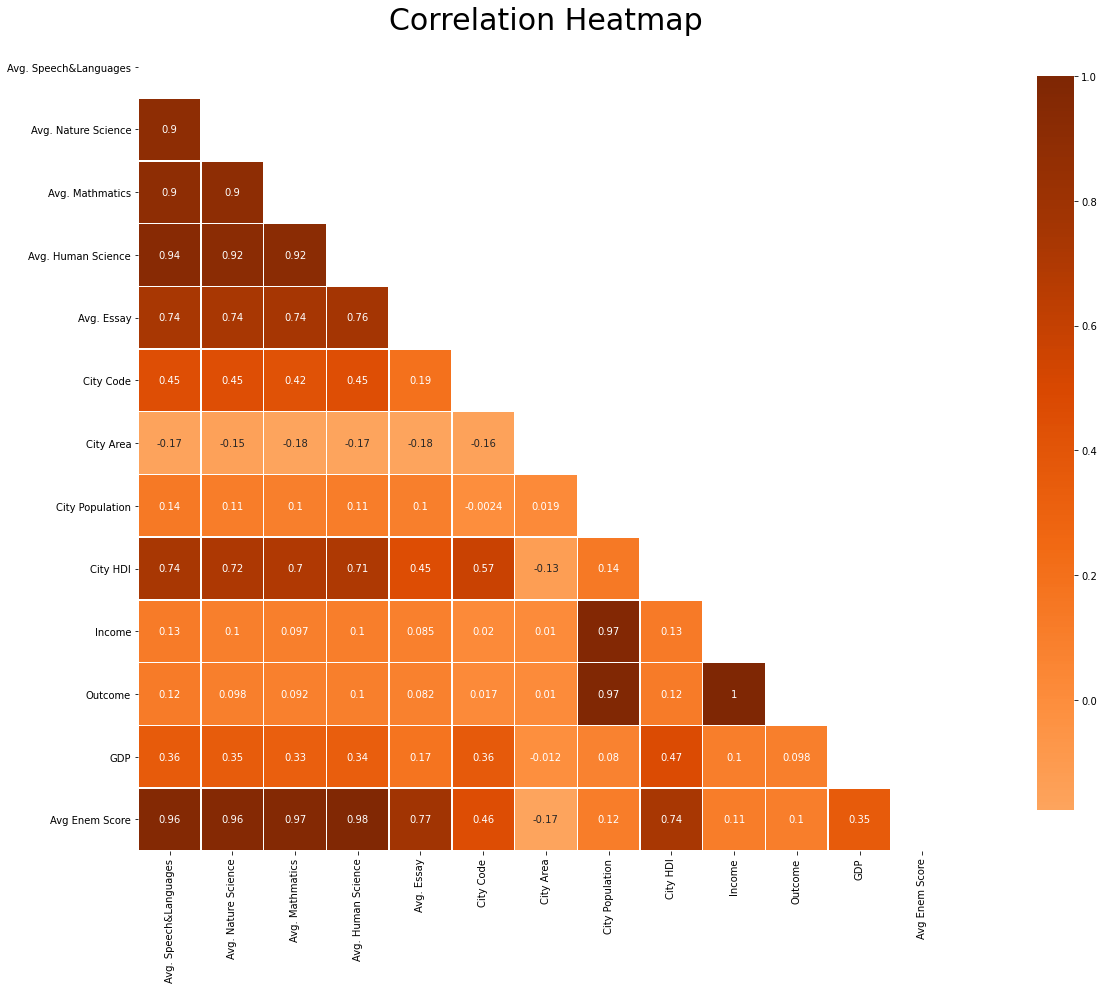

In [192]:
# Creating a correlation heatmap
corr_df.columns = ['Avg. Speech&Languages','Avg. Nature Science', 'Avg. Mathmatics', 'Avg. Human Science',
                'Avg. Essay', 'City Code', 'City Area', 'City Population', 'City HDI', 'Income', 'Outcome', 'GDP']
corr_df['Avg Enem Score'] = (corr_df['Avg. Speech&Languages'] + corr_df['Avg. Nature Science'] + corr_df['Avg. Mathmatics'] + 
                    corr_df['Avg. Human Science'])/4
corr = corr_df.corr()
plot_corr_heatmap(corr)

In [193]:
corr_df['PopulationRange'] = pd.cut(corr_df['City Population'], 
                                    np.array([0, 50000, 100000,200000, 500000, 1000000, 100000000]), 
                                    labels=['0-50k', '50k-100k', '100k-200k', '200k-500k', '500k-1000k', '>1000k'],
                                   duplicates = 'drop')


<ipython-input-193-da99c00d9f42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['PopulationRange'] = pd.cut(corr_df['City Population'],


In [194]:
corr_df.head()

,Avg. Speech&Languages,Avg. Nature Science,Avg. Mathmatics,Avg. Human Science,Avg. Essay,City Code,City Area,City Population,City HDI,Income,Outcome,GDP,Avg Enem Score,PopulationRange
0,495.248506,492.796024,491.780633,496.131508,527.012802,2609402,196.072,62784,0.652,1.078221e+05,9.788656e+04,10989.60,493.989168,50k-100k
1,500.012571,506.211833,499.279917,508.968077,534.663395,1400100,5687.037,399213,0.752,1.224794e+06,1.049568e+06,26924.03,503.618100,200k-500k
2,507.112637,508.465169,527.478090,523.709890,551.318681,3166907,209.270,7669,0.677,2.068443e+04,1.869679e+04,15957.83,516.691446,0-50k
3,500.293889,504.591720,520.939490,524.868889,550.333333,3166808,1295.272,11582,0.696,4.677767e+04,3.792587e+04,30096.24,512.673497,0-50k
4,528.953563,524.490280,537.587320,538.024156,546.954239,4119152,60.869,132157,0.751,4.255719e+05,3.425651e+05,43213.64,532.263830,100k-200k


<BarContainer object of 5570 artists>

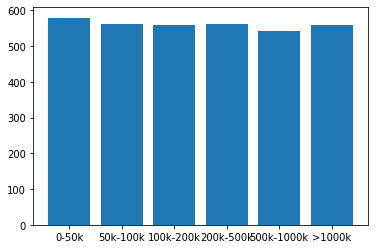

In [195]:
sortedDF = corr_df.sort_values(by=['City Population'])
plt.bar(sortedDF['PopulationRange'], corr_df['Avg Enem Score'])

In [196]:
# Geolocation
city = pd.read_csv('data/geoloc/Codigo_Nome_Municipios.txt',
                   encoding='latin-1', delimiter=';', names=['codMun', 'UF', 'nameMun'], skiprows=1)


After loading all datasets, some verifications is going to be made and sanity checks will be performed in order to understand and validate the data.

In [197]:
# It is impossible to have more cities in ENEM database than total cities in Brazil
assert len(enemScore.CO_MUNICIPIO_RESIDENCIA.unique()) <= len(city.codMun.unique())
print('Passed! ' + 'ENEM score database has '+ str(len(enemScore.CO_MUNICIPIO_RESIDENCIA.unique())) + 
      ' cities in its database and there are ' + str(len(city.codMun)) + ' cities in Brazil')


assert len(enemSocial.CO_MUNICIPIO_RESIDENCIA.unique()) <= len(city.codMun.unique())
print('Passed! ' + 'ENEM social database has '+ str(len(enemSocial.CO_MUNICIPIO_RESIDENCIA.unique())) + 
      ' cities in its database and there are ' + str(len(city.codMun)) + ' cities in Brazil')

Passed! ENEM score database has 5570 cities in its database and there are 5570 cities in Brazil
Passed! ENEM social database has 5570 cities in its database and there are 5570 cities in Brazil


In [198]:
# All averages must not be greater than 1.000 (max score)
for grade in enemScore.columns:
    if grade.startswith('avg'):
        assert enemScore[grade].max() < 1000
        print('Passed! '+ grade+ ' has the max value of '+ str(round(enemScore[grade].max(),2)))

Passed! avg(NU_NOTA_CN) has the max value of 565.88
Passed! avg(NU_NOTA_COMP3) has the max value of 140.0
Passed! avg(NU_NOTA_MT) has the max value of 632.4
Passed! avg(NU_NOTA_COMP4) has the max value of 137.83
Passed! avg(NU_NOTA_CH) has the max value of 587.66
Passed! avg(NU_NOTA_COMP5) has the max value of 113.03
Passed! avg(NU_NOTA_REDACAO) has the max value of 673.91
Passed! avg(NU_NOTA_COMP1) has the max value of 143.12
Passed! avg(NU_NOTA_COMP2) has the max value of 145.71
Passed! avg(NU_NOTA_LC) has the max value of 558.04


In [199]:
# All averages must not be greater than 1.000 (max score)
for grade in enemSocial.columns:
    if grade.startswith('avg'):
        assert enemSocial[grade].max() < 1000
        print('Passed! '+ grade+ ' has the max value of '+ str(round(enemSocial[grade].max(),2)))

Passed! avg(NU_NOTA_CN) has the max value of 565.88
Passed! avg(NU_NOTA_MT) has the max value of 632.4
Passed! avg(NU_NOTA_CH) has the max value of 587.66
Passed! avg(NU_NOTA_REDACAO) has the max value of 673.91
Passed! avg(NU_NOTA_LC) has the max value of 558.04
